<a href="https://colab.research.google.com/github/kk221/AllWomenTech_Projects/blob/Text_embedding/Text_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Embeddings

Before you start working on this notebook, have a look to this [blogpost](https://towardsdatascience.com/bow-to-bert-2695cdb19787).

The general goal in NLP is to learn from text data by transforming it into a vector-like format while keeping the semantic meaning of each word and its context. This vector-like format is what we will call embeddings.

Now, depending on the goal of our project, we may aim to have embeddings for each word in our text or for representing the whole text (i.e. all the text from each of the restaurant reviews).

Coming back to the machine learning protocol, embeddings are vectors that will be used to feed a model (i.e. classifier, linear model, clustering, neural network, etc) to train it and make predictions. Depending on the data science problem that we face we will use one or another model, we will deep dive into different use cases in the next days.

In this notebook we are going to focus on producing embeddings that describe the whole text, each of the restaurant reviews. We are going to start from the traditional and more intuitive methods:
* Bag of Words (BOW)
* TF-IDF

In [ ]:
import re
import time
import nltk
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import wordnet
from datetime import datetime
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
def visualize_wordcloud_dict_frequencies(dict_freqs, title, relative_scaling=0.5, max_words=100,
                                background_color='black'):
    plt.figure(figsize=(10, 10))
    wordcloud = WordCloud(width=900, height=500, max_words=max_words, relative_scaling=relative_scaling,
                          normalize_plurals=False, background_color=background_color).generate_from_frequencies(
        dict_freqs)
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Load data

In [ ]:
# Load the data
! pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth                    # Other necessary packages
from oauth2client.client import GoogleCredentials
auth.authenticate_user()                         # Follow prompt in the authorization process
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

In [ ]:
drive = GoogleDrive(gauth)
data = drive.CreateFile({'id': '1IO1QIaE3EoaPMa5_An-vhTOGIRdS6R7h'})   # "your_module_file_id" is the part after "id=" in the shareable link 
data.GetContentFile('Ex 6.4 ratings.csv')                        # Save the module file to Colab VM
# csv : https://drive.google.com/open?id=1IO1QIaE3EoaPMa5_An-vhTOGIRdS6R7h
# Add the name of the file
filename = 'Ex 6.4 ratings.csv'

In [ ]:
data = pd.read_csv(filename)

In [ ]:
data.shape

(1319968, 4)

In [ ]:
samples = data['review'].dropna()

## Bag of Words

In [ ]:
start = time.time()

matrix = CountVectorizer(max_features=100)
X = matrix.fit_transform(samples).toarray()

end = time.time()
print("It took {} sec to fit and transform all documents.".format(end - start))

It took 47.795472860336304 sec to fit and transform all documents.


In [ ]:
# Build the column names dictionary -> ordered dataframe
bow_dict = matrix.vocabulary_
df_baw_voc = pd.DataFrame({'column_name': list(bow_dict.keys()), 'column_index': list(bow_dict.values())})
df_baw_voc = df_baw_voc.sort_values(by='column_index')

In [ ]:
# Build the matrix dataframe with the right columns
df_X = pd.DataFrame(X)
df_X.columns = df_baw_voc['column_name'].tolist()

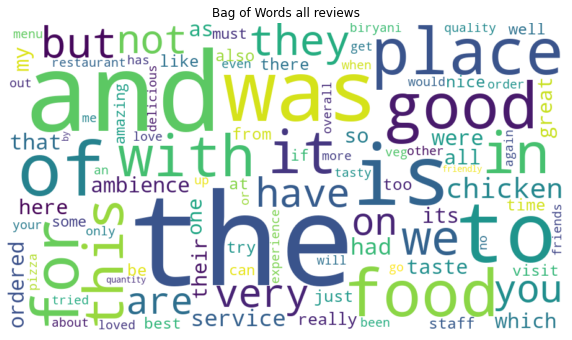

In [ ]:
title="Bag of Words all reviews"
d_freq_bow = df_X.sum().to_dict()
visualize_wordcloud_dict_frequencies(d_freq_bow, title, relative_scaling=0.5, max_words=1000,
                                background_color='white')

Exercise 1.

You are transforming 1319968 reviews into vectors of 100 dimensions in 48s.

**Q1: Do you think that Sklearn is doing this operation column or row based?**

- Rows, it takes word frequency into account

**Q2: Compare with the time that it took the tokenization of reviews through a row based iterative process in the previous notebook.**

- By using `nltk.word_tokenize(text)`, the transformating time increased to 354 sec - almost 6 mins. ﾉ)ﾟДﾟ( 

In [ ]:
# new dataframe - samples

samples.head(3)

0    A beautiful place to dine inThe interiors take...
1    I was here for dinner with my family on a week...
2    Its a restaurant near to Banashankari BDA Me a...
Name: review, dtype: object

In [ ]:
nltk.download('punkt')

In [ ]:
start = time.time()

def nltkTokenize(text):
    words = nltk.word_tokenize(text)
    return words

data['tokenized_text'] = samples.apply(lambda row: nltkTokenize(row))

end = time.time()
print("It took {} sec to fit and transform all documents.".format(end - start))

It took 354.3302547931671 sec to fit and transform all documents.


### Remove Stopwords

Exercise 2. 

**Q1: Do you see in the wordcloud words that you would consider as stopwords?** 

- `bow_vectorizer = CountVectorizer(max_features=100,stop_words='english')`

**Q2: Rerun the cells and have a look to the wordcloud, which words have highest frequency now?**

- place, food, good, chicken, service

In [ ]:
start = time.time()

#We initiate the vectorizer
bow_vectorizer = CountVectorizer(max_features=100,stop_words='english')

#We fit and transform our clean dataset
X_bow = bow_vectorizer.fit_transform(samples)

#We create a dataset with the results
bow_data=pd.DataFrame(X_bow.toarray())
bow_data.columns=bow_vectorizer.get_feature_names()

end = time.time()
print("It took {} sec to fit and transform all documents.".format(end - start))

It took 42.74372744560242 sec to fit and transform all documents.


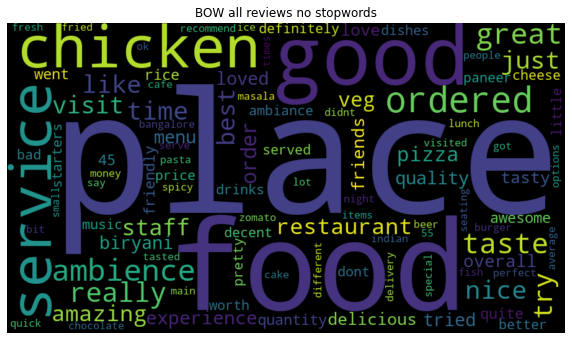

In [ ]:
# wordcloud - without stopwords
title="BOW all reviews no stopwords"
d_freq_bow = bow_data.sum().to_dict()
visualize_wordcloud_dict_frequencies(d_freq_bow, title, relative_scaling=0.5, max_words=1000,
                                background_color='black')

### Checking machine memory

Exercise 3-1. 

**Q1: Check out the RAM memory bar while you transform the reviews into vectors of bags of words**

- `CountVectorizer(max_features=100)`

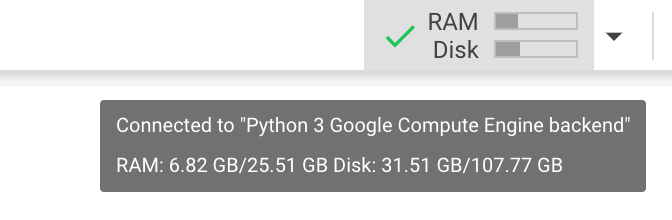

- `CountVectorizer(max_features=100,stop_words='english')`


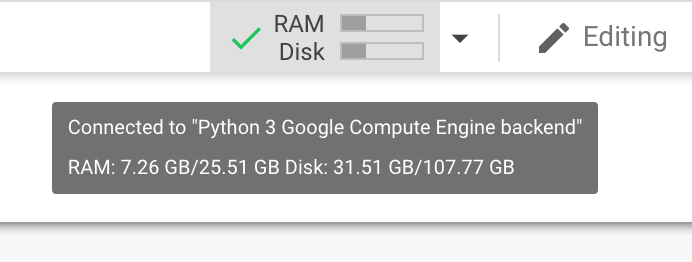



In [ ]:
# upload and save image to colab
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [ ]:
# calling uplaod function - with stopwords
upload_files()

Saving Screenshot 2020-05-24 at 1.47.23 AM.png to Screenshot 2020-05-24 at 1.47.23 AM.png


['Screenshot 2020-05-24 at 1.47.23 AM.png']

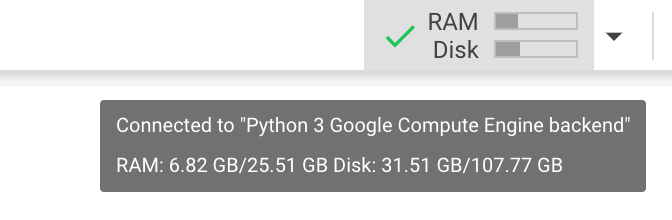

In [ ]:
# open the image - with stopwords
from IPython.display import Image
Image('Screenshot 2020-05-24 at 1.47.23 AM.png')

In [ ]:
# calling uplaod function - without stopwords
upload_files()

Saving Screenshot 2020-05-24 at 1.59.00 AM.png to Screenshot 2020-05-24 at 1.59.00 AM.png


['Screenshot 2020-05-24 at 1.59.00 AM.png']

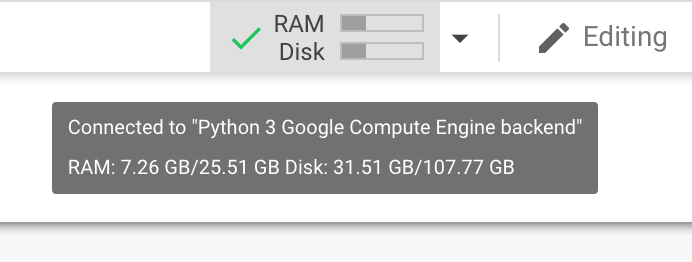

In [ ]:
# open the image - without stopwords
from IPython.display import Image
Image('Screenshot 2020-05-24 at 1.59.00 AM.png')

Exercise 3-2.


The parameter "max_features" will determine the number of words that will define each of the reviews in your dataset (the dimensions). 

**Q2: Play around with it visualizing the wordcloud from each setup and argument which number is the optimal from your perspective and for which goal do you think it is optimal.**

- `max_features = 50`



> When decreasing the `max_features`, we get less noise with the top frequent review words, but we will miss some details about what food the reviewers like, and why they like the place. It all depends on the aim of the analysis. 



In [ ]:
start = time.time()

#We initiate the vectorizer
bow_vectorizer2 = CountVectorizer(max_features=50,stop_words='english')

#We fit and transform our clean dataset
X_bow2 = bow_vectorizer2.fit_transform(samples)

#We create a dataset with the results
bow_data2=pd.DataFrame(X_bow2.toarray())
bow_data2.columns=bow_vectorizer2.get_feature_names()

end = time.time()
print("It took {} sec to fit and transform all documents.".format(end - start))

It took 42.834664821624756 sec to fit and transform all documents.


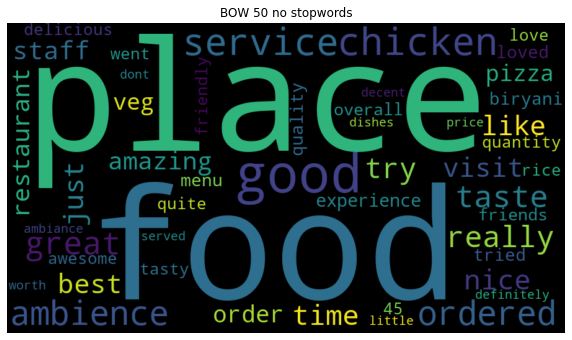

In [ ]:
# wordcloud - without stopwords
title="BOW 50 no stopwords"
d_freq_bow2 = bow_data2.sum().to_dict()
visualize_wordcloud_dict_frequencies(d_freq_bow2, title, relative_scaling=0.5, max_words=1000,
                                background_color='black')

## TF-IDF

In [ ]:
start = time.time()

vectorizer = TfidfVectorizer(max_df=0.5, min_df=0.1)
X_tfidf = vectorizer.fit_transform(samples)

end = time.time()
print("It took {} sec to fit and transform all documents.".format(end - start))

It took 47.12677025794983 sec to fit and transform all documents.


In [ ]:
X_tfidf.shape

(1316924, 57)

In [ ]:
# Build the column names dictionary -> ordered dataframe
tfidf_dict = vectorizer.vocabulary_
df_tf_idf_voc = pd.DataFrame({'column_name': list(tfidf_dict.keys()), 'column_index': list(tfidf_dict.values())})
df_tf_idf_voc = df_tf_idf_voc.sort_values(by='column_index')

In [ ]:
# Build the matrix dataframe with the right columns
df_X_tfidf = pd.DataFrame(X_tfidf.toarray())
df_X_tfidf.columns = df_tf_idf_voc['column_name'].tolist()

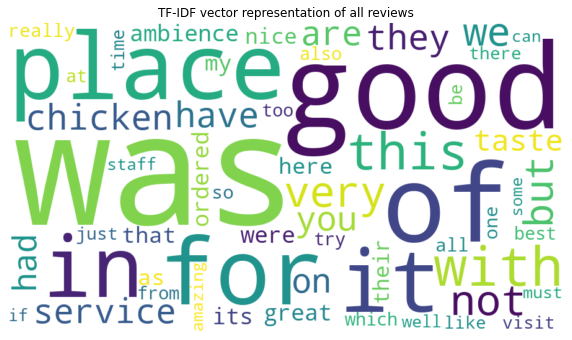

In [ ]:
title="TF-IDF vector representation of all reviews"
d_freq_tfidf = df_X_tfidf.sum().to_dict()
visualize_wordcloud_dict_frequencies(d_freq_tfidf, title, relative_scaling=0.5, max_words=500,
                                background_color='white')

Exercise 4. 

**Q1: As in the previous section, find out how to exclude stopwords and play around to find the best model hyperparameters `max_df` and `min_df`.**

**Q2: Based on which criteria did you choose those ones?**

### Remove Stopwords

In [ ]:


start = time.time()

#We initiate the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=0.1,stop_words='english')

#We fit and transform our clean dataset
X_tfidf = tfidf_vectorizer.fit_transform(samples)

#We create a dataset with the results
tfidf_data=pd.DataFrame(X_tfidf.toarray())
tfidf_data.columns=tfidf_vectorizer.get_feature_names()

end = time.time()
print("It took {} sec to fit and transform all documents.".format(end - start))

It took 41.69367575645447 sec to fit and transform all documents.


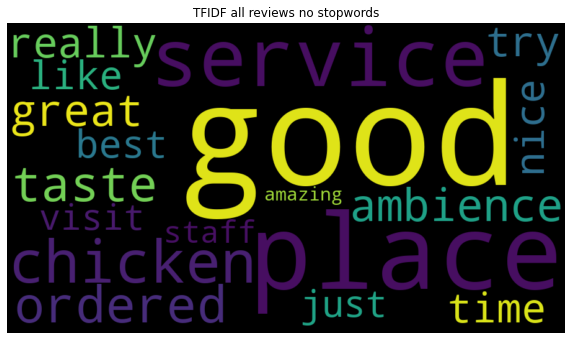

In [ ]:
# wordcloud - without stopwords
title="TFIDF all reviews no stopwords"
d_freq_tfidf = tfidf_data.sum().to_dict()
visualize_wordcloud_dict_frequencies(d_freq_tfidf, title, relative_scaling=0.5, max_words=1000,
                                background_color='black')

### `max_df` and `min_df`

- the more % we take from `max_df`, the more noise we see, with `max_df = 0.4`, the frequent words changed to Chicken,Service, Order and Taste, more concertrated with **FOOD**
- the more % we take from `min_df`, the more info we lose, with `min_df = 0.2`, we ignore more frequent words, only left five: Place, Good, Service, Ambience, Ordered

In [ ]:
# Resource: https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

#max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
#max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
#max_df = 25 means "ignore terms that appear in more than 25 documents".
#The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

In [ ]:
#min_df is used for removing terms that appear too infrequently. For example:
#min_df = 0.1 means "ignore terms that appear in less than 10% of the documents".
#min_df = 5 means "ignore terms that appear in less than 5 documents".
#The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

#### change `max_df`

In [ ]:
start = time.time()

#We initiate the vectorizer
tfidf_vectorizer2 = TfidfVectorizer(max_df=0.4, min_df=0.1,stop_words='english')

#We fit and transform our clean dataset
X_tfidf2 = tfidf_vectorizer2.fit_transform(samples)

#We create a dataset with the results
tfidf_data2=pd.DataFrame(X_tfidf2.toarray())
tfidf_data2.columns=tfidf_vectorizer2.get_feature_names()

end = time.time()
print("It took {} sec to fit and transform all documents.".format(end - start))

It took 42.76829147338867 sec to fit and transform all documents.


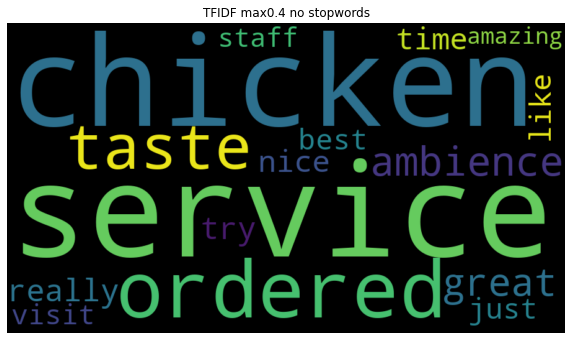

In [ ]:
# wordcloud - without stopwords
title="TFIDF max0.4 no stopwords"
d_freq_tfidf2 = tfidf_data2.sum().to_dict()
visualize_wordcloud_dict_frequencies(d_freq_tfidf2, title, relative_scaling=0.5, max_words=1000,
                                background_color='black')

#### change `min_df`

In [ ]:
start = time.time()

#We initiate the vectorizer
tfidf_vectorizer3 = TfidfVectorizer(max_df=0.5, min_df=0.2,stop_words='english')

#We fit and transform our clean dataset
X_tfidf3 = tfidf_vectorizer3.fit_transform(samples)

#We create a dataset with the results
tfidf_data3=pd.DataFrame(X_tfidf3.toarray())
tfidf_data3.columns=tfidf_vectorizer3.get_feature_names()

end = time.time()
print("It took {} sec to fit and transform all documents.".format(end - start))

It took 41.39408087730408 sec to fit and transform all documents.


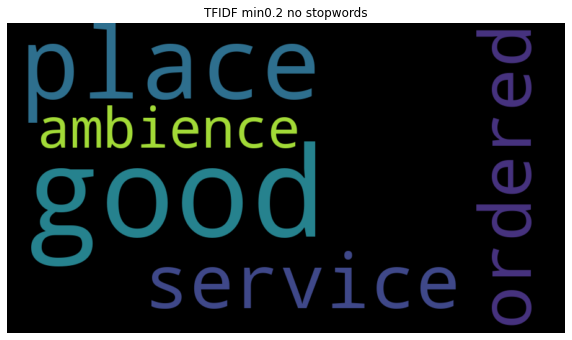

In [ ]:
# wordcloud - without stopwords
title="TFIDF min0.2 no stopwords"
d_freq_tfidf3 = tfidf_data3.sum().to_dict()
visualize_wordcloud_dict_frequencies(d_freq_tfidf3, title, relative_scaling=0.5, max_words=1000,
                                background_color='black')

## Cosine similarity between reviews

Most likely you realized during the exercises that the optimization of the embeddings may be perform with a specific goal (i.e. capture words related to sentiment to predict reviews rating).

In order to evaluate the type of semantic information captured in the embeddings generated, we can use pairwise distance metric (similarity metric) in order to know which reviews are more closed based on the encoded knowledge by each setup.

For high dimensional vectors we will use cosine distance or cosine similarity metric.

#### Get vectors of products with reviews containing food words

In [ ]:
# We want to know whether reviews that are similar to one with high frequency on
# the word "great" are also positive reviews and the other way around. Let's use 
# review number "1162740" as our reference.
tfidf_data['great'].sort_values().tail()

128477     1.0
1163482    1.0
1219850    1.0
1162740    1.0
447785     1.0
Name: great, dtype: float64

In [ ]:
#We'll take one review that contains "great"
samples.iloc[1162740]

'Love the Tandoori Paneer and Corn Spinach special grill sandwich and Fire in the Hole stoned ice icream The rolled ice creams are also very tasty and great'

In [ ]:
# Make a copy of the original df to avoid problems with different dimensionality
df_X_tfidf_ = tfidf_data.copy()

# Have a look to the Sklearn method "cosine_similarity" to know how to calculate cosine
# similarity. It requires two matrices. Here we're computing the cosine similarity of 
# the review 1162740 against all the other ones
reference_review_matrix = np.expand_dims(np.array(df_X_tfidf_.iloc[1162740].values), axis=0)
distances_to_reference_review = cosine_similarity(reference_review_matrix, df_X_tfidf_)

In [ ]:
#Let's create a dataframe with the results
sim_df = pd.DataFrame(distances_to_reference_review).transpose()
sim_df.head()

,0
0,0.000000
1,0.000000
2,0.000000
3,0.632539
4,0.000000


In [ ]:
# Get the most similar
similar = sim_df.nlargest(10,[0])
for i in similar.index:
    print (samples.iloc[i],"\n")

Honestly have only tried parcels and that too only starters and mains  never tried desserts So this review is based on starters and mains only The quality wasnt all that great was pretty average 

Great food and proper Karnataka style full meals Been there twice and was fully satisfied Will give 5 stars if its well managed 

Honestly have only tried parcels and that too only starters and mains  never tried desserts So this review is based on starters and mains only The quality wasnt all that great was pretty average 

food wasnt that great 

food wasnt that great 

food wasnt that great 

food wasnt that great 

the order was quite late but the guy at chat survive was quite sympathetic and the food was great 

Didnt get the gravy mentioned on the menu But food otherwise great 

Didnt get the gravy mentioned on the menu But food otherwise great 



**Q:What's going on? Check for duplicates and repeat the process to get most similar reviews.**

In [ ]:
# duplicates
samples.duplicated().sum()


1191158

In [ ]:
# drop duplicates
samples.drop_duplicates()

0          A beautiful place to dine inThe interiors take...
1          I was here for dinner with my family on a week...
2          Its a restaurant near to Banashankari BDA Me a...
3          We went here on a weekend and one of us had th...
4          The best thing about the place is its ambiance...
                                 ...                        
1317583    More than the food i guess the happy lively an...
1317584    Today evening I visited this place \nBest thin...
1317824    A fine place to chill after office hours reaso...
1317825    Thank God bhagini replaced the old and phathet...
1317826    Decent place Havent tried the Andhra meal yet ...
Name: review, Length: 125766, dtype: object

In [ ]:
# Get the most similar after dropping duplicates
similar = sim_df.nlargest(10,[0])
for i in similar.index:
    print (samples.drop_duplicates().iloc[i],"\n")

I love the desserts more than anything here Good place and well served 
We dint like the nachos here  it was not that good as we expected 
Except nachos almost all dish were quite good 

Had been here good food served and tastygood place to go with freinds and family should be first to get served well with all food One of the good hotel there for this price 

pathetic food 

Took more than 2 hours to deliver the food and the restaurant just doesnt receive the calls 

Didnt receive 

Very bad food quality ordered at 300 AM Restaurant Dint agree to exchange the order items when I tried to reach immediately after placing order Prefer not to order once again  

found cockroach in fooddisgustingplace should be banned 

An amazing Baker who bakes good quality cakes and varieties She is just super in making any kind of cakes with amazing texture and finishing The best part about her cakes is that is home made and maintains cleanliness and use all fresh items 

Authentic tasty food priced reas

In [ ]:
# Get the most dis-similar
dissimilar = sim_df.nsmallest(10,[0])
for i in dissimilar.index:
    print (samples.drop_duplicates().iloc[i],"\n")

A beautiful place to dine inThe interiors take you back to the Mughal era The lightings are just perfectWe went there on the occasion of Christmas and so they had only limited items available But the taste and service was not compromised at allThe only complaint is that the breads could have been betterWould surely like to come here again 

I was here for dinner with my family on a weekday The restaurant was completely empty Ambience is good with some good old hindi music Seating arrangement are good too We ordered masala papad panner and baby corn starters lemon and corrionder soup butter roti olive and chilli paratha Food was fresh and good service is good too Good for family hangout
Cheers 

Its a restaurant near to Banashankari BDA Me along with few of my office friends visited to have buffet but unfortunately they only provide veg buffet On inquiring they said this place is mostly visited by vegetarians Anyways we ordered ala carte items which took ages to come Food was ok ok Defi

Exercise 5. 

**Q: Is this the separation of reviews that you expected to split by customer satisfaction?**

- No, not really, in both similar reviews and disimilar reviews, it appears good and bad reviews. My though is to use VADAR score and compare the compond.

If not, play around with the two methods for text embeddings, its hyper parameters and the code until you feel familiar with the whole process. Now try to find the best embeddings.